Finetuning Llama3 8B on Solana smart contract vulnerability analysis

Credits to the Github
<div class="align-center">
  <a href="https://github.com/unslothai/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
</div>


Installing Dependencies

In [1]:
%%capture
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps "xformers<0.0.27" "trl<0.9.0" peft accelerate bitsandbytes

Using Unsloth/FastLanguageModel to to effeciently load the model

In [2]:
# Importing the necessary dependencies

from unsloth import FastLanguageModel
from transformers import TextStreamer
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported
from datasets import load_dataset
import torch
import matplotlib.pyplot as plt

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


In [4]:
max_seq_length = 2048
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True  # loading weights/biases in 4 bits


model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/llama-3-8b-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models
)

# The model is loaded

==((====))==  Unsloth: Fast Llama patching release 2024.8
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.1+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.26.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/464 [00:00<?, ?B/s]

_________

<h1>Inference  without finetuning</h1>

<h3>Data Prep</h3>
We are going to use this synthetically created Alpaca dataset    
<a href="https://huggingface.co/datasets/ArmurAI/Solana_Smart_contract_audit">Solana SC<a>


In [11]:
# @title Solana Smart Contract
ExampleCode ='''
use {
    solana_client::rpc_client::RpcClient,
    solana_sdk::{
        instruction::Instruction,
        pubkey::Pubkey,
        signer::{
            keypair::{read_keypair_file, write_keypair_file, Keypair},
            Signer,
        },
        transaction::Transaction,
        {borsh::try_from_slice_unchecked, program_pack::Pack},
    },
    spl_token::state::{Account, Mint},
    spl_token_metadata::{
        instruction::{create_master_edition, create_metadata_accounts},
        state::{Metadata, EDITION, PREFIX},
    },
    std::{io, io::Write, thread, time},
};

const CLIENT_URL: &'static str = "https://api.devnet.solana.com";
const WALLET_FILE_PATH: &'static str = "wallet.keypair";

fn get_wallet() -> Keypair {
    let wallet_keypair: Keypair = if let Ok(keypair) = read_keypair_file(WALLET_FILE_PATH) {
        keypair
    } else {
        let new_keypair = Keypair::new();
        write_keypair_file(&new_keypair, WALLET_FILE_PATH).unwrap();
        new_keypair
    };

    return wallet_keypair;
}

fn create_mint_account(wallet_keypair: &Keypair, client: &RpcClient) -> Pubkey {
    let mint_account: Keypair = Keypair::new();
    let mint_account_pubkey = mint_account.pubkey();
    let wallet_pubkey = wallet_keypair.pubkey();

    let minimum_balance_for_rent_exemption = client
        .get_minimum_balance_for_rent_exemption(Mint::LEN)
        .unwrap();

    let create_account_instruction: Instruction = solana_sdk::system_instruction::create_account(
        &wallet_pubkey,
        &mint_account_pubkey,
        minimum_balance_for_rent_exemption,
        Mint::LEN as u64,
        &spl_token::id(),
    );
    let initialize_mint_instruction: Instruction = spl_token::instruction::initialize_mint(
        &spl_token::id(),
        &mint_account_pubkey,
        &wallet_pubkey,
        None,
        0,
    )
    .unwrap();

    let (recent_blockhash, _fee_calculator) = client.get_recent_blockhash().unwrap();

    let transaction: Transaction = Transaction::new_signed_with_payer(
        &vec![create_account_instruction, initialize_mint_instruction],
        Some(&wallet_pubkey),
        &[&mint_account, &wallet_keypair],
        recent_blockhash,
    );

    let result = client.send_and_confirm_transaction_with_spinner(&transaction);

    if result.is_ok() {
        println!(
            "Successfully created a Mint Account with Pubkey: {:?}",
            mint_account_pubkey
        )
    };

    return mint_account_pubkey;
}

fn create_token_account(
    wallet_keypair: &Keypair,
    mint_account_pubkey: &Pubkey,
    client: &RpcClient,
) -> Pubkey {
    let wallet_pubkey = wallet_keypair.pubkey();
    let account_mint_to: Keypair = Keypair::new();
    let account_mint_to_pubkey: Pubkey = account_mint_to.pubkey();

    let create_account_instruction: Instruction = solana_sdk::system_instruction::create_account(
        &wallet_pubkey,
        &account_mint_to_pubkey,
        client
            .get_minimum_balance_for_rent_exemption(Account::LEN)
            .unwrap(),
        Account::LEN as u64,
        &spl_token::id(),
    );
    let initialize_account2_instruction: Instruction = spl_token::instruction::initialize_account2(
        &spl_token::id(),
        &account_mint_to_pubkey,
        &mint_account_pubkey,
        &wallet_pubkey,
    )
    .unwrap();

    let (recent_blockhash, _fee_calculator) = client.get_recent_blockhash().unwrap();

    let transaction: Transaction = Transaction::new_signed_with_payer(
        &vec![create_account_instruction, initialize_account2_instruction],
        Some(&wallet_pubkey),
        &[&wallet_keypair, &account_mint_to],
        recent_blockhash,
    );

    let result = client.send_and_confirm_transaction_with_spinner(&transaction);
    if result.is_ok() {
        println!(
            "Successfully created a Token Account with Pubkey: {:?}",
            account_mint_to_pubkey
        )
    };

    return account_mint_to_pubkey;
}

fn mint_nft(
    wallet_keypair: &Keypair,
    mint_account_pubkey: &Pubkey,
    token_account_pubkey: &Pubkey,
    client: &RpcClient,
) {
    let wallet_pubkey = wallet_keypair.pubkey();

    let mint_to_instruction: Instruction = spl_token::instruction::mint_to(
        &spl_token::id(),
        &mint_account_pubkey,
        &token_account_pubkey,
        &wallet_pubkey,
        &[&wallet_pubkey],
        1,
    )
    .unwrap();

    let (recent_blockhash, _fee_calculator) = client.get_recent_blockhash().unwrap();
    let transaction: Transaction = Transaction::new_signed_with_payer(
        &vec![mint_to_instruction],
        Some(&wallet_pubkey),
        &[wallet_keypair],
        recent_blockhash,
    );

    let result = client.send_and_confirm_transaction_with_spinner(&transaction);
    if result.is_ok() {
        println!("Successfully Minted NFT to : {:?}", wallet_pubkey);

        upgrade_to_master_edition(
            &wallet_keypair,
            &create_metadata_account(&wallet_keypair, &mint_account_pubkey, &client),
            &mint_account_pubkey,
            &client,
        );
    };
}

fn create_metadata_account(
    wallet_keypair: &Keypair,
    mint_account_pubkey: &Pubkey,
    client: &RpcClient,
) -> Pubkey {
    let wallet_pubkey = wallet_keypair.pubkey();

    let program_key = spl_token_metadata::id();
    let metadata_seeds = &[
        PREFIX.as_bytes(),
        &program_key.as_ref(),
        mint_account_pubkey.as_ref(),
    ];
    let (metadata_key, _) = Pubkey::find_program_address(metadata_seeds, &program_key);

    // Test Metadata
    let name = String::from("Jeff NFT");
    let symbol = String::from(J");
    let uri = String::from("https://solana.com");

    let new_metadata_instruction = create_metadata_accounts(
        program_key,
        metadata_key,
        *mint_account_pubkey,
        wallet_pubkey,
        wallet_pubkey,
        wallet_pubkey,
        name,
        symbol,
        uri,
        None,
        0,
        false,
        false,
    );

    let (recent_blockhash, _fee_calculator) = client.get_recent_blockhash().unwrap();

    let transaction: Transaction = Transaction::new_signed_with_payer(
        &vec![new_metadata_instruction],
        Some(&wallet_pubkey),
        &[wallet_keypair],
        recent_blockhash,
    );

    let result = client.send_and_confirm_transaction_with_spinner(&transaction);
    if result.is_ok() {
        println!(
            "Successfully created a new Metadata Account with Pubkey: {:?}",
            metadata_key
        )
    };

    return metadata_key;
}

fn upgrade_to_master_edition(
    wallet_keypair: &Keypair,
    metadata_key: &Pubkey,
    mint_account_pubkey: &Pubkey,
    client: &RpcClient,
) {
    let wallet_pubkey = wallet_keypair.pubkey();
    let program_key = spl_token_metadata::id();

    let metadata_account = client.get_account(&metadata_key).unwrap();
    let metadata: Metadata = try_from_slice_unchecked(&metadata_account.data).unwrap();

    let master_edition_seeds = &[
        PREFIX.as_bytes(),
        &program_key.as_ref(),
        &metadata.mint.as_ref(),
        EDITION.as_bytes(),
    ];
    let (master_edition_key, _) = Pubkey::find_program_address(master_edition_seeds, &program_key);

    let master_edition_instruction = create_master_edition(
        program_key,
        master_edition_key,
        *mint_account_pubkey,
        wallet_pubkey,
        wallet_pubkey,
        *metadata_key,
        wallet_pubkey,
        Some(1),
    );

    let (recent_blockhash, _fee_calculator) = client.get_recent_blockhash().unwrap();
    let transaction: Transaction = Transaction::new_signed_with_payer(
        &vec![master_edition_instruction],
        Some(&wallet_pubkey),
        &[wallet_keypair],
        recent_blockhash,
    );

    let result = client.send_and_confirm_transaction_with_spinner(&transaction);

    if result.is_ok() {
        println!("Upgraded Metadata Account to Master Edition!");
    } else {
        println!("{:?}", result);
        return;
    }

    let master_metadata: Metadata = try_from_slice_unchecked(&metadata_account.data).unwrap();

    println!("\nSnapshot of Master Edition Metadata\n");
    println!("key: {:#?}", master_metadata.key);
    println!("update_authority: {:#?}", master_metadata.update_authority);
    println!("mint: {:#?}", master_metadata.mint);
    println!(
        "name: {:#?}",
        master_metadata.data.name.trim_end_matches(char::from(0))
    );
    println!(
        "symbol: {:#?}",
        master_metadata.data.symbol.trim_end_matches(char::from(0))
    );
    println!(
        "uri: {:#?}",
        master_metadata.data.uri.trim_end_matches(char::from(0))
    );
    println!(
        "seller_fee_basis_points: {:#?}",
        master_metadata.data.seller_fee_basis_points
    );
}

fn main() {
    // Get our Wallet KeyPair
    let wallet_keypair = get_wallet();
    let wallet_pubkey: Pubkey = wallet_keypair.pubkey();

    let program_key = spl_token_metadata::id();
    println!("{:?}", program_key);

    // Connect to the Solana Client and pull our wallet balance
    let client = RpcClient::new(CLIENT_URL.to_string());
    let wallet_balance = client.get_balance(&wallet_pubkey).unwrap();

    println!("Wallet Pubkey: {}", wallet_pubkey);
    println!("Wallet Balance: {}", wallet_balance);

    // Airdrop funds if our wallet is empty
    if wallet_balance == 0 {
        let result = client.request_airdrop(&wallet_keypair.pubkey(), 10_000_000_000);

        if result.is_ok() {
            print!("Airdropping funds to {:?}", wallet_pubkey);
            io::stdout().flush().unwrap();
            while client.get_balance(&wallet_pubkey).unwrap() == 0 {
                print!(".");
                io::stdout().flush().unwrap();
                let one_second = time::Duration::from_millis(1000);
                thread::sleep(one_second);
            }
            println!("");
        } else {
            println!("Failed to Airdrop funds. Try again later.");
            return;
        }
    }

    // Create the required prelim accounts
    let mint_account_pubkey = create_mint_account(&wallet_keypair, &client);
    let token_account_pubkey = create_token_account(&wallet_keypair, &mint_account_pubkey, &client);

    // Create the NFT, including the Metadata associated with it
    mint_nft(
        &wallet_keypair,
        &mint_account_pubkey,
        &token_account_pubkey,
        &client,
    );

    return;
}
'''

In [ ]:
alpaca_prompt = """You are an expert in Solana smart contract development and security auditing. Your task is to analyze the provided Solana smart contract and provide a comprehensive security analysis. Check for common vulnerabilities specific to Solana contracts
please provide a detailed explanation for each vulnerability
### Smart Contract:
{}

### Vulnerabilities:
{}"""

FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        ExampleCode,
        ""
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 128)
predictions = tokenizer.batch_decode(outputs, skip_special_tokens = True)
gen_out = predictions[0]
gen_res = gen_out[gen_out.index("### Vulnerabilities:")+len("### Vulnerabilities:")+1:]
print(gen_res)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


- [ ] Solana Client
    - [ ] RPCClient
        - [ ] RpcClient::new(CLIENT_URL.to_string())
            - [ ] CLIENT_URL is a static string
            - [ ] CLIENT_URL is a hard-coded value
            - [ ] CLIENT_URL is a constant value
            - [ ] CLIENT_URL is a static value
            - [ ] CLIENT_URL is a fixed value
            - [ ] CLIENT_URL is a hardcoded value
            - [ ] CLIENT_URL is a literal value
            - [ ] CLIENT_URL is a hard coded value
            - [ ] CLIENT_URL is a static string


As you can see the output is very vague.
We are going to fix that using **Finetuning**

---------

<h1>Finetuning

In [5]:
#Generating Peft version of the model to

model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)

Unsloth 2024.8 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


<h2>Mapping the dataset</h2>

In [6]:
alpaca_prompt = """You are an expert in Solana smart contract development and security auditing. Your task is to analyze the provided Solana smart contract and provide a comprehensive security analysis. Check for common vulnerabilities specific to Solana contracts

### Smart Contract:
{}

### Vulnerabilities:
{}"""

data_link = "ArmurAI/Solana_vulnerability_audit_dataset_V2"

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    scs       = examples["code"]
    vul     =  examples["vulnerabilities"]
    texts = []
    for s,v in zip(scs,vul):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!

        output_desired = '''The vulnerabilities found in the following code are : \n'''
        for i in range(len(v)):
            output_desired+= (str(i+1)+ ") " + str(v[i]) +"\n")
        v1 = output_desired
        text = alpaca_prompt.format(s,v1) + EOS_TOKEN
        texts.append(text)

    return { "text" : texts, }
pass

## Loading the dataset

# hugging face datase
dataset = load_dataset(data_link, split = "train")

# local file as a dataset (Please upload it in the folder)
#dataset = load_dataset("json", data_files="data.json", split = "train")

dataset = dataset.map(formatting_prompts_func, batched = True,)

Generating train split:   0%|          | 0/180 [00:00<?, ? examples/s]

Map:   0%|          | 0/180 [00:00<?, ? examples/s]

<a name="Train"></a>
<h3>Train the model</h3>
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

In [7]:
# Defining SFTTrainer

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 60,  # Depends on the model
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

Map (num_proc=2):   0%|          | 0/180 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


----------

<h2> Training</h2>

In [8]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 180 | Num Epochs = 3
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 60
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
1,0.596800
2,0.612800
3,0.974200
4,0.671600
5,0.570000
6,0.586500
7,0.654200
8,0.386300
9,0.397200
10,0.396900


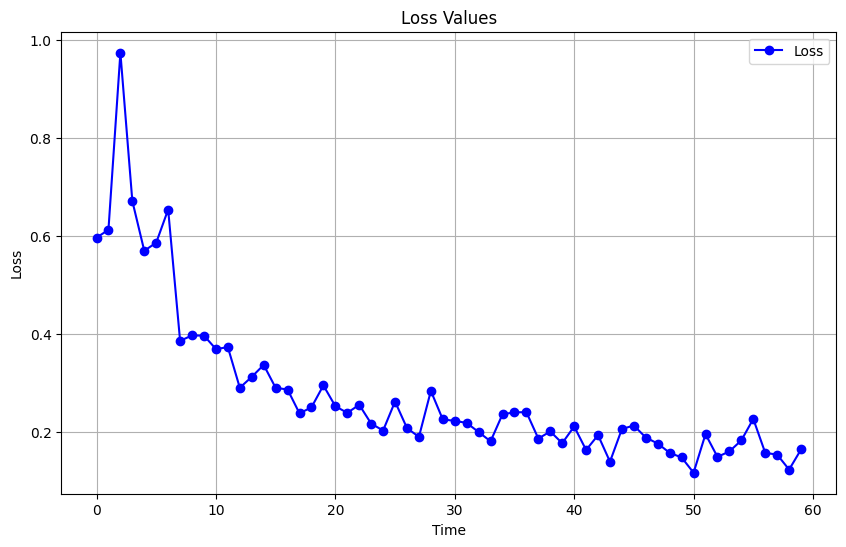

In [9]:
loss = []
data_loss = trainer.state.log_history
for i in range(len(data_loss)-1):
    loss.append(data_loss[i]["loss"])

indices = list(range(len(loss)))

# Plotting the loss values
plt.figure(figsize=(10, 6))
plt.plot(indices, loss, 'b-', marker='o', label='Loss')
plt.xlabel('Time')
plt.ylabel('Loss')
plt.title('Loss Values')
plt.legend()
plt.grid(True)
plt.show()

<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

 You can also use a `TextStreamer` for continuous inference - so you can see the generation token by token, instead of waiting the whole time!

In [12]:
# alpaca_prompt = Copied from above
alpaca_prompt = """You are an expert in Solana smart contract development and security auditing. Your task is to analyze the provided Solana smart contract and provide a comprehensive security analysis. Check for all common vulnerabilities specific to Solana contracts

### Smart Contract:
{}

### Vulnerabilities:
{}"""



FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        ExampleCode,
        ""
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 128)
predictions = tokenizer.batch_decode(outputs, skip_special_tokens = True)
gen_out = predictions[0]
gen_res = gen_out[gen_out.index("### Vulnerabilities:")+len("### Vulnerabilities:")+1:]
print(gen_res)

The vulnerabilities found in the following code are : 
1) Centralization risk: The contract creates a single point of failure by relying on a single wallet for critical operations
2) Unchecked external calls: The contract makes external calls without verifying the result, potentially exposing the contract to reentrancy attacks
3) Insufficient access control: The contract lacks proper access control mechanisms, allowing unauthorized users to perform restricted actions



This output is way better and precise, after checking the code manually these are the exact vulnerabilities found in the smart contract

In [ ]:
model.save_pretrained_merged("model", tokenizer, save_method = "lora",)
model.push_to_hub_merged("hf/model", tokenizer, save_method = "lora", token = "")

Save your model to huggingface

<h1>And we are done ..🥳</h1>